### Interquartile range (IQR)

In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df_lung = pd.read_csv("Lung_CRISPR.csv", index_col=0)
index = df_lung.index.tolist()
idx = [ i.split('(', 1)[0].strip() for i in index]
df_lung.reset_index(drop=True)
df2_lung = pd.DataFrame(df_lung.to_numpy(), index=idx, columns=df_lung.columns)
df2_lung

,Lung ACH-000012,Lung ACH-000015,Lung ACH-000021,Lung ACH-000029,Lung ACH-000030,Lung ACH-000035,Lung ACH-000143,Lung ACH-000150,Lung ACH-000161,Lung ACH-000187,...,Lung ACH-000176,Lung ACH-000282,Lung ACH-000442,Lung ACH-000562,Lung ACH-000666,Lung ACH-000894,Lung ACH-000945,Lung ACH-001137,Lung ACH-001233,Lung ACH-002156
A1BG,-0.108980,-0.189235,-0.105938,-0.021076,-0.016582,-0.067664,-0.119212,0.125060,-0.014279,-0.073889,...,-0.054437,0.034093,0.057533,-0.133443,-0.003102,-0.026487,0.097041,-0.066143,-0.058657,-0.106796
A1CF,0.058620,-0.035974,-0.128983,0.021592,-0.252811,0.010632,-0.259819,0.055429,-0.018668,0.073300,...,0.074430,0.169736,0.205212,0.214558,-0.139011,-0.065532,0.232760,0.068774,-0.156786,0.136343
A2M,0.172384,-0.081227,-0.031955,0.061565,0.061437,0.013058,-0.032307,-0.107358,0.078105,-0.114860,...,-0.020439,-0.132270,-0.154406,0.030255,0.245718,-0.097719,0.006453,0.066938,-0.004401,0.047201
A2ML1,0.223336,0.040641,-0.037817,0.124352,0.127381,0.031293,-0.072596,0.067760,0.098264,0.115993,...,0.169129,-0.066514,0.239753,0.190899,-0.081751,0.131874,-0.025697,0.213979,0.119160,0.261219
A3GALT2,0.119961,0.073002,-0.008492,-0.202661,-0.111409,-0.039283,-0.032018,-0.074665,-0.118834,-0.187936,...,0.023983,-0.216107,-0.325557,-0.006391,-0.027773,-0.194807,-0.155381,-0.230956,0.005990,-0.255882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.022825,-0.002087,-0.011769,0.018795,-0.064730,-0.227280,0.085573,-0.076451,0.036753,-0.001422,...,-0.074062,-0.060480,-0.124188,0.069443,-0.023997,0.017859,-0.028109,-0.042222,-0.100133,-0.118193
ZYG11B,-0.067238,-0.123983,-0.210983,-0.067246,-0.197020,-0.347596,-0.101911,0.013915,-0.005542,-0.004455,...,-0.137992,-0.171666,-0.118732,-0.163424,-0.029105,-0.343399,-0.163772,-0.334588,-0.101049,-0.217907
ZYX,-0.138806,-0.090832,-0.292636,0.007300,0.051397,-0.054946,0.006333,0.044104,-0.074138,0.018319,...,0.106957,-0.142906,0.091290,0.085370,-0.051036,0.086529,-0.039301,0.043595,-0.030006,0.062295
ZZEF1,-0.063841,-0.182880,-0.127955,-0.091112,-0.076670,-0.039142,0.115756,-0.188083,-0.065650,-0.097660,...,0.037841,-0.442399,-0.117184,-0.225227,-0.004863,-0.059501,-0.327515,-0.323785,-0.209962,-0.319088


[0.87915571 0.00560359]


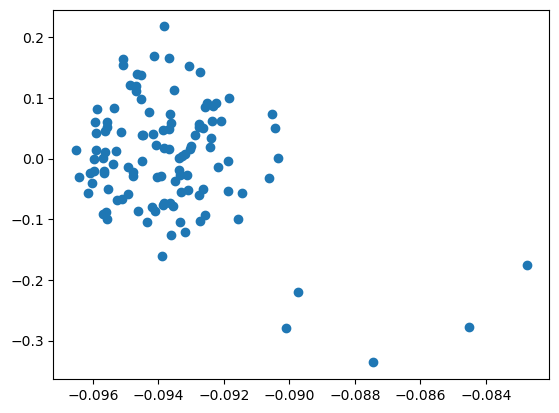

In [11]:
X = df2_lung.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)
#X_pca = pca.fit_transform(df2_lung.to_numpy())
print(pca.explained_variance_ratio_)
X_res = pca.components_
plt.scatter(X_res[0], X_res[1] )
#plt.scatter(X_pca[:,0], X_pca[:,1] )

In [3]:
def determine_outlier_iqr(dataframe, row_name, th1=0.25, th3=0.75):
    quartile1 = dataframe.loc[row_name].quantile(th1)
    quartile3 = dataframe.loc[row_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

rows = df2_lung.index.tolist()
tmp = []
res = df2_lung.copy()
out_mask = None
for row in rows:
    lower_limit, upper_limit = determine_outlier_iqr(df2_lung, row, 0.25, 0.75)
    #print(lower_limit, upper_limit)
   # tmp.append(df2_lung.loc[row, (df2_lung.loc[row] <= lower_limit) | (df2_lung.loc[row] >= upper_limit)])
    out_mask = (df2_lung.loc[row] <= lower_limit) | (df2_lung.loc[row] >= upper_limit)
    res.loc[row, out_mask] = None
res

    #print(tmp)
    #print("")
#outliners = pd.DataFrame(tmp)
#df_cleaned = df2_lung.drop(outliners.columns)
#outliners

,Lung ACH-000012,Lung ACH-000015,Lung ACH-000021,Lung ACH-000029,Lung ACH-000030,Lung ACH-000035,Lung ACH-000143,Lung ACH-000150,Lung ACH-000161,Lung ACH-000187,...,Lung ACH-000176,Lung ACH-000282,Lung ACH-000442,Lung ACH-000562,Lung ACH-000666,Lung ACH-000894,Lung ACH-000945,Lung ACH-001137,Lung ACH-001233,Lung ACH-002156
A1BG,-0.108980,-0.189235,-0.105938,-0.021076,-0.016582,-0.067664,-0.119212,0.125060,-0.014279,-0.073889,...,-0.054437,0.034093,0.057533,-0.133443,-0.003102,-0.026487,0.097041,-0.066143,-0.058657,-0.106796
A1CF,0.058620,-0.035974,-0.128983,0.021592,-0.252811,0.010632,-0.259819,0.055429,-0.018668,0.073300,...,0.074430,0.169736,0.205212,0.214558,-0.139011,-0.065532,0.232760,0.068774,-0.156786,0.136343
A2M,0.172384,-0.081227,-0.031955,0.061565,0.061437,0.013058,-0.032307,-0.107358,0.078105,-0.114860,...,-0.020439,-0.132270,-0.154406,0.030255,NaN,-0.097719,0.006453,0.066938,-0.004401,0.047201
A2ML1,0.223336,0.040641,-0.037817,0.124352,0.127381,0.031293,-0.072596,0.067760,0.098264,0.115993,...,0.169129,-0.066514,0.239753,0.190899,-0.081751,0.131874,-0.025697,0.213979,0.119160,0.261219
A3GALT2,0.119961,0.073002,-0.008492,-0.202661,-0.111409,-0.039283,-0.032018,-0.074665,-0.118834,-0.187936,...,0.023983,-0.216107,-0.325557,-0.006391,-0.027773,-0.194807,-0.155381,-0.230956,0.005990,-0.255882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.022825,-0.002087,-0.011769,0.018795,-0.064730,-0.227280,0.085573,-0.076451,0.036753,-0.001422,...,-0.074062,-0.060480,-0.124188,0.069443,-0.023997,0.017859,-0.028109,-0.042222,-0.100133,-0.118193
ZYG11B,-0.067238,-0.123983,-0.210983,-0.067246,-0.197020,-0.347596,-0.101911,0.013915,-0.005542,-0.004455,...,-0.137992,-0.171666,-0.118732,-0.163424,-0.029105,-0.343399,-0.163772,-0.334588,-0.101049,-0.217907
ZYX,-0.138806,-0.090832,NaN,0.007300,0.051397,-0.054946,0.006333,0.044104,-0.074138,0.018319,...,0.106957,-0.142906,0.091290,0.085370,-0.051036,0.086529,-0.039301,0.043595,-0.030006,0.062295
ZZEF1,-0.063841,-0.182880,-0.127955,-0.091112,-0.076670,-0.039142,0.115756,-0.188083,-0.065650,-0.097660,...,0.037841,NaN,-0.117184,-0.225227,-0.004863,-0.059501,-0.327515,-0.323785,-0.209962,-0.319088


remove outliners

In [8]:
res.isna().sum(axis=1).to_csv("irq_nan.csv")

In [9]:
! ls -lthr

total 42M
-rw-rw-r-- 1 emanuele emanuele 4.1K Aug  3 16:16 Active-Learning.ipynb
-rw-rw-r-- 1 emanuele emanuele  38M Aug  3 16:47 Lung_CRISPR.csv
-rw-rw-r-- 1 emanuele emanuele 6.0K Aug  3 17:01 Curated_Bagel_Non_Essential_Genes.txt
-rw-rw-r-- 1 emanuele emanuele 2.0K Aug  3 17:01 Curated_Bagel_Essential_Genes.txt
-rw-rw-r-- 1 emanuele emanuele 1.7M Aug  4 11:01 12864_2021_8129_MOESM1_ESM.xlsx
-rw-rw-r-- 1 emanuele emanuele  24K Aug  4 12:10 curated_bagel.xlsx
-rw-rw-r-- 1 emanuele emanuele  11K Aug  4 12:11 curated_bagel.csv
-rw-rw-r-- 1 emanuele emanuele 6.4K Aug  4 12:17 adam_essential.csv
-rw-rw-r-- 1 emanuele emanuele 6.0K Aug  4 12:36 curated_bagel_not_essential.csv
-rw-rw-r-- 1 emanuele emanuele 126K Aug  4 15:13 CRIPSRIndex.csv
-rw-rw-r-- 1 emanuele emanuele  56K Aug  8 11:38 SSL_01.ipynb
-rw-rw-r-- 1 emanuele emanuele 133K Aug  9 10:26 LabelSpreading_lung.csv
-rw-rw-r-- 1 emanuele emanuele  11K Aug  9 10:38 Otsu_lung_essentials.csv
-rw-rw-r-- 1 emanuele emanuele  36K Aug  9 10

In [4]:
res.shape, res.dropna(axis=1, thresh=res.shape[0]*0.95).shape

((17453, 114), (17453, 97))

In [7]:
#res = res.loc[:, res.isnull().sum() < 0.1*res.shape[0]]
res_new = res.loc[:, res.isnull().sum() < 0.1*res.shape[0]]
res_new.shape

(17453, 109)

KNN impute outliners

In [24]:
from sklearn.impute import KNNImputer

def impute_data(df):
    # Imputing data by means of K-Nearest Neighbours algo
    print(f" if existing missing values: Imputing data ...")
    knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')
    df_knn = df.copy()
    columns_Nans = df_knn.columns[df_knn.isna().any()].to_list()
    if len(columns_Nans) != 0:
        df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns, index=df_knn.index)
    return df_knn_imputed

In [25]:
res_knn = impute_data(res_new)

 if existing missing values: Imputing data ...


In [ ]:
#res.dropna(axis=1, thresh=res.shape[0]*0.95, inplace=True)
#res.fillna(res.median(), inplace=True)

In [26]:
X_drop_scaled = scaler.fit_transform(res_knn.to_numpy())
pca2 = PCA(n_components=2)
pca2.fit(X_drop_scaled)
print(pca2.explained_variance_ratio_)
X_drop = pca2.components_

#plt.subplot(2,1,1)
#plt.scatter(X_res[0], X_res[1] )

[0.90468694 0.00429217]


In [13]:
X_res

array([[-0.09382353, -0.09388037, -0.09427523, -0.09530267, -0.09538116,
        -0.09526647, -0.09257402, -0.09236508, -0.09349764, -0.09263122,
        -0.08744009, -0.09045127, -0.09508029, -0.09367073, -0.0946742 ,
        -0.09271845, -0.0931028 , -0.09596753, -0.09535534, -0.09354598,
        -0.08450882, -0.09218755, -0.09335409, -0.09603219, -0.09569389,
        -0.09587744, -0.0935207 , -0.09476133, -0.09568096, -0.09391751,
        -0.09469435, -0.09010159, -0.09360922, -0.0955231 , -0.09299708,
        -0.09556059, -0.09414697, -0.09242062, -0.09275172, -0.09486036,
        -0.09477395, -0.09063441, -0.09418385, -0.09511581, -0.09589013,
        -0.09407871, -0.09563802, -0.09366288, -0.09317886, -0.09365719,
        -0.09402971, -0.0956171 , -0.09289096, -0.09491308, -0.0955964 ,
        -0.09223586, -0.09328064, -0.09035393, -0.09493745, -0.09273983,
        -0.09335188, -0.09263076, -0.09307284, -0.09250267, -0.09613741,
        -0.09209963, -0.094343  , -0.0964169 , -0.0

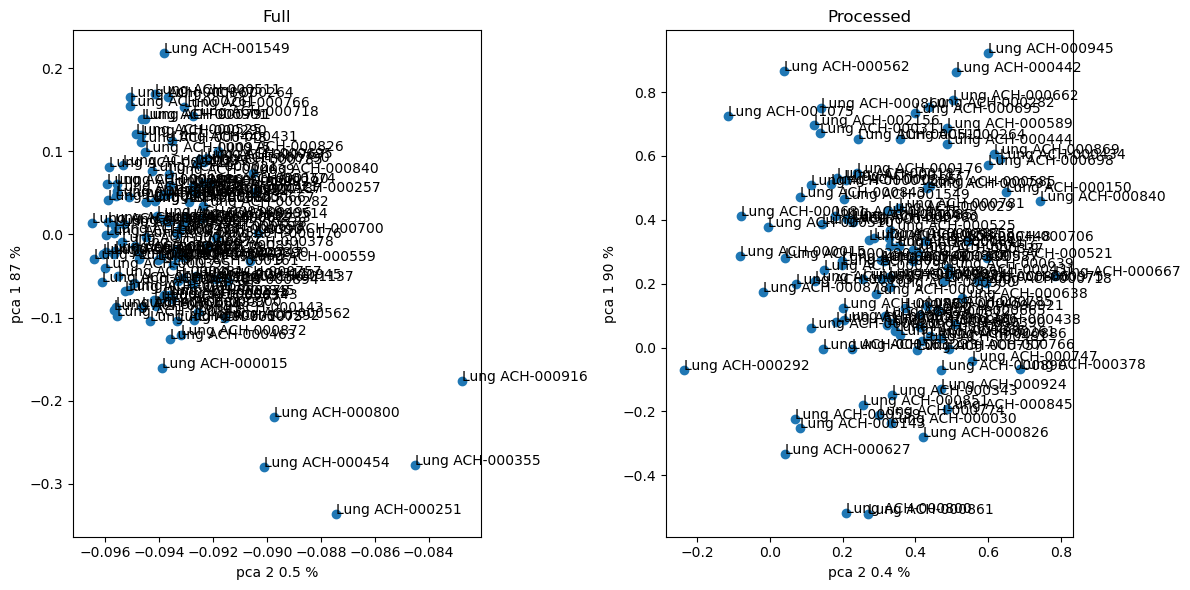

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].scatter(X_res[0], X_res[1])
ax[1].scatter(X_drop_scaled[0], X_drop_scaled[1])

x0, y0 = X_res[0], X_res[1]
for i, txt in enumerate(df2_lung.columns):
    ax[0].annotate(txt, (x0[i], y0[i]))
    ax[0].set_ylabel('pca 1 87 %')
    ax[0].set_xlabel('pca 2 0.5 %')
    ax[0].set_title('Full')

x1, y1 = X_drop_scaled[0], X_drop_scaled[1]
for i, txt in enumerate(res_knn.columns):
    ax[1].annotate(txt, (x1[i], y1[i]))
    ax[1].set_ylabel('pca 1 90 %')
    ax[1].set_xlabel('pca 2 0.4 %')
    ax[1].set_title('Processed')
    
plt.tight_layout()
#plt.savefig("iqr_n_knn.png")
    

In [29]:
res_knn.to_csv("processed_Lung_CRISPR.csv")